<a href="https://colab.research.google.com/github/yichichandesu/short-term-volatility/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Set-Up and Configuration

In [1]:
import pandas as pd
import numpy as np
import gc
from pathlib import Path
from google.colab import drive
import time

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define Paths
BASE_PATH = Path('/content/drive/MyDrive/Colab Notebooks/crypto_data')
MONARQ_PATH = BASE_PATH / 'monarq_data'
FUNDING_PATH = BASE_PATH / 'processed_funding' # Where we saved the funding parquets earlier
OUTPUT_PATH = BASE_PATH / 'processed_final'    # Where we will save the final features

# Create output directory
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# 3. Define Symbols & Constants
TARGET_SYMBOLS = ["BTCUSDT", "ETHUSDT"]
DATA_TYPES = ["trade_1min", "level1_1min", "book_1min", "openinterest_1min"]
TYPE_PREFIX = {
    "trade_1min": "tr",
    "level1_1min": "l1",
    "book_1min": "l2",
    "openinterest_1min": "oi"
}

# 4. Processed Parquet Files Check
processed_funding_check = True
processed_final_check = True

print(f"Reading Raw Data from: {MONARQ_PATH}")
print(f"Saving Parquets to: {OUTPUT_PATH}")

Mounted at /content/drive
Reading Raw Data from: /content/drive/MyDrive/Colab Notebooks/crypto_data/monarq_data
Saving Parquets to: /content/drive/MyDrive/Colab Notebooks/crypto_data/processed_final


In [2]:

import torch
import torch.nn as nn

class VolatilityLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        """
        Args:
            input_size (int): Number of features (e.g., 10 tech indicators).
            hidden_size (int): Number of neurons in the LSTM hidden state.
            num_layers (int): Number of stacked LSTM layers.
            output_size (int): Number of values to predict (usually 1 for volatility).
            dropout (float): Dropout rate to prevent overfitting.
        """
        super(VolatilityLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. The LSTM Layer
        # batch_first=True means input shape is (Batch, Seq_Len, Features)
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout
        )

        # 2. The Fully Connected (Linear) Layer
        # Maps the hidden state to the final volatility output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden states with zeros (optional, PyTorch does this by default)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        # out shape: (Batch_Size, Seq_Length, Hidden_Size)
        out, _ = self.lstm(x)

        # Decode the hidden state of the LAST time step
        # We only care about the final prediction after seeing the whole window
        last_time_step_out = out[:, -1, :]

        # Pass through the Linear layer to get the final prediction
        prediction = self.fc(last_time_step_out)

        return prediction

# 1. Microstructure Processor

In [3]:
def process_microstructure_and_save(symbol):
    print(f"\n=== Processing Microstructure: {symbol} ===")

    # 1. Load and Merge Raw Data Types (Trade, L1, L2, OI)
    # (This part is the same as before - loading CSVs)
    dfs = []
    for dt in DATA_TYPES:
        folder = MONARQ_PATH / dt / symbol
        prefix = TYPE_PREFIX.get(dt, dt)
        files = sorted(folder.glob("*.csv.gz"))

        if not files: continue

        type_dfs = []
        for f in files:
            try:
                temp = pd.read_csv(f)
                type_dfs.append(temp)
            except: pass

        if type_dfs:
            df_type = pd.concat(type_dfs, ignore_index=True)
            if "ts_end" in df_type.columns:
                df_type["ts_end"] = pd.to_datetime(df_type["ts_end"], unit="ms", utc=True)
                df_type = df_type.sort_values("ts_end").set_index("ts_end")
                df_type = df_type[~df_type.index.duplicated(keep="last")]
                df_type = df_type.rename(columns={c: f"{prefix}__{c}" for c in df_type.columns})
                dfs.append(df_type)

    if not dfs: return False

    print("Joining data types...")
    df = dfs[0]
    for d in dfs[1:]:
        df = df.join(d, how="outer")

    df = df.sort_index()

    # ==============================================================================
    # 2. FULL FEATURE ENGINEERING
    # ==============================================================================
    print("   wv Calculating ALL Features...")
    eps = 1e-8

    # --- A. Basic Price/Vol ---
    df["dt"] = df.index
    df["symbol"] = symbol
    if "tr__close_price" in df.columns:
        df["ret_1m"] = df["tr__close_price"].pct_change()
        df["abs_ret_1m"] = df["ret_1m"].abs() # Added from Cell 21
        df["rv_30m"] = df["ret_1m"].pow(2).rolling(30, min_periods=10).sum()

    if "tr__volume" in df.columns:
        df["log_volume"] = np.log1p(df["tr__volume"].astype(float)) # Added from Cell 21

    # --- B. Order Flow Imbalance (OFI) ---
    if "tr__buy_volume" in df.columns and "tr__sell_volume" in df.columns:
        df["OFI_raw"] = df["tr__buy_volume"] - df["tr__sell_volume"]

        # OFI Derived Features
        df["OFI_std_30m"] = df["OFI_raw"].rolling(30, min_periods=10).std()

        ofi_lag10 = df["OFI_raw"].shift(10)
        df["OFI_roc_10m"] = (df["OFI_raw"] - ofi_lag10) / (ofi_lag10.abs() + eps)

        # VPIN Proxy (Volume-Synchronized Probability of Informed Trading)
        buy_v = df["tr__buy_volume"]
        sell_v = df["tr__sell_volume"]
        df["VPIN_proxy"] = (buy_v - sell_v).abs() / (buy_v + sell_v + eps)

    # --- C. L1 Order Book Features ---
    if "l1__close_bid_size" in df.columns:
        bid_sz = df["l1__close_bid_size"]
        ask_sz = df["l1__close_ask_size"]
        df["L1_Imbalance"] = (bid_sz - ask_sz) / (bid_sz + ask_sz + eps)

        # Liquidity Weighted OFI
        if "OFI_raw" in df.columns:
            depth = df.get("l1__mean_bid_size", 0) + df.get("l1__mean_ask_size", 0)
            df["Liquidity_Weighted_OFI"] = df["OFI_raw"] * depth

    if "l1__mean_spread" in df.columns:
        df["Mean_Spread"] = df["l1__mean_spread"]
        df["Spread_ma_15m"] = df["l1__mean_spread"].rolling(15, min_periods=5).mean()

    # --- D. Advanced Microstructure ---
    # VWAP Deviation
    if "tr__vwap" in df.columns and "tr__close_price" in df.columns:
        df["VWAP_deviation"] = (df["tr__vwap"] - df["tr__close_price"]) / (df["tr__close_price"] + eps)

    # Trade Intensity
    if "tr__trade_count" in df.columns:
        df["Trade_Intensity"] = df["tr__trade_count"]

    # Price Impact
    if "tr__close_price" in df.columns and "tr__volume" in df.columns:
        ret_15m = df["tr__close_price"].pct_change(15)
        vol_15m = df["tr__volume"].rolling(15, min_periods=5).sum()
        df["Price_Impact_per_Volume"] = ret_15m.abs() / (vol_15m + eps)

    # --- E. L2 Order Book (Depth Ratios) ---
    # Only if Level 2 data exists
    if "l2__bid_10000K_fill_dsize" in df.columns:
        b_10m = df["l2__bid_10000K_fill_dsize"]
        a_10m = df["l2__ask_10000K_fill_dsize"]
        df["depth_ratio_10M"] = b_10m / (a_10m + eps)
        df["l2_imbalance_10M"] = (b_10m - a_10m) / (b_10m + a_10m + eps)

    # ==============================================================================
    # 3. SAVE TO PARQUET
    # ==============================================================================
    out_file = OUTPUT_PATH / f"{symbol}_micro_features.parquet"
    df.to_parquet(out_file)
    print(f"Saved {len(df)} rows to {out_file.name} (With ALL features)")

    # 4. Clean Memory
    del df
    del dfs
    gc.collect()
    return True

if not processed_funding_check:
  # --- RUN THE UPDATE ---
  for sym in TARGET_SYMBOLS:
      process_microstructure_and_save(sym)

# 3. Merging Dataset

In [4]:
def finalize_dataset(symbol):
    print(f"\n=== Finalizing {symbol} ===")

    # 1. Load Microstructure Features (Fast Read)
    micro_file = OUTPUT_PATH / f"{symbol}_micro_features.parquet"
    if not micro_file.exists():
        print(f"Missing microstructure file for {symbol}")
        return

    df = pd.read_parquet(micro_file)

    # 2. Load and Merge Funding Rate
    # Note: Using the processed_funding folder we created previously
    fund_file = FUNDING_PATH / f"{symbol}_funding_clean.parquet"

    if fund_file.exists():
        funding_df = pd.read_parquet(fund_file)

        # Resample Funding to 1-min (Forward Fill)
        funding_df = funding_df.set_index("dt").sort_index()
        funding_1min = funding_df["rate"].resample("1min").ffill().to_frame("funding_rate")

        # Merge onto main dataframe
        # Ensure df has datetime index or column 'dt'
        if "dt" in df.columns:
            df = df.set_index("dt")

        df = df.join(funding_1min, how="left")
        print("gw Funding rate merged.")
    else:
        print("Funding file not found, filling NaNs.")
        df["funding_rate"] = np.nan

    # 3. Create Targets (Future Volatility)
    # Target: Realized Volatility 5 mins into the future
    if "ret_1m" in df.columns:
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
        df["rv_fwd_5m"] = df["ret_1m"].pow(2).rolling(window=indexer).sum().pow(0.5)
        print("Target (rv_fwd_5m) created.")

        # Create Lags (e.g., Volatility 5 mins ago)
        df["rv_30m_lag5"] = df["rv_30m"].shift(5)

    # 4. Save FINAL Dataset
    final_file = OUTPUT_PATH / f"{symbol}_final_train.parquet"
    df.to_parquet(final_file)
    print(f"Saved Final: {final_file.name}")

    # 5. Purge
    del df
    gc.collect()

if not processed_final_check:
  # --- RUN PHASE 2 ---
  for sym in TARGET_SYMBOLS:
      finalize_dataset(sym)

# 4. LSTM Data Preparation

In [5]:
def load_training_data(symbol):
    """
    Loads the finalized parquet file for symbol
    """

    file_path = OUTPUT_PATH / f"{symbol}_final_train.parquet"

    if file_path.exists():
        print(f"   Reading parquet: {file_path.name}")
        return pd.read_parquet(file_path)
    else:
        print(f"   Error: File not found for {symbol}")
        return None

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import gc

def select_best_features(symbol="BTCUSDT", corr_threshold=0.95, vif_threshold=10, top_n=20):
    print(f"Running 3-Step Feature Selector on {symbol}...")

    # 1. Load Sample and Setup
    file_path = OUTPUT_PATH / f"{symbol}_final_train.parquet"
    if not file_path.exists(): return []

    df = pd.read_parquet(file_path)

    # Sample size
    df_sample = df.iloc[:30000].fillna(0)

    target_col = "rv_fwd_5m"
    drop_cols = ["symbol", "dt", "ts_end", "source_file", target_col]

    # Filter numeric only
    feature_cols = [c for c in df_sample.columns if c not in drop_cols]
    feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_sample[c])]

    X = df_sample[feature_cols].copy()
    y = df_sample[target_col]

    # Cleaning for numerical stability
    X.replace([np.inf, -np.inf], 0, inplace=True)
    X = X.loc[:, (X != X.iloc[0]).any()] # Zero variance check
    X.dropna(inplace=True)

    print(f"   Starting with {X.shape[1]} clean features.")

    # ==============================================================================
    # STEP 1: CORRELATION FILTER (Coarse Cleaning)
    # ==============================================================================
    print(f"   1/3: Correlation Filter (Corr > {corr_threshold})")
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    corr_to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X_corr_clean = X.drop(columns=corr_to_drop)

    print(f"      Dropped {len(corr_to_drop)} features. Remaining: {X_corr_clean.shape[1]}")

    # ==============================================================================
    # STEP 2: VIF FILTER (Fine Cleaning / Multicollinearity Check)
    # ==============================================================================
    print(f"   2/3: VIF Filter (VIF < {vif_threshold})")

    # Add constant for VIF calculation
    X_vif = add_constant(X_corr_clean)

    dropped = True
    while dropped:
        dropped = False
        vif_data = pd.Series(
            [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
            index=X_vif.columns
        ).drop('const', errors='ignore')

        max_vif = vif_data.max()
        max_feature = vif_data.idxmax()

        # If max VIF is too high, drop that feature and re-calculate
        if max_vif > vif_threshold and len(X_vif.columns) > 1:
            # Only print every few drops to keep output clean
            if len(X_vif.columns) % 5 == 0:
                print(f"      ... Dropping '{max_feature}' (VIF={max_vif:.1f})")

            X_vif = X_vif.drop(columns=[max_feature])
            dropped = True

    clean_features = [c for c in X_vif.columns if c != 'const']
    print(f"      Remaining unique features: {len(clean_features)}")

    # ==============================================================================
    # STEP 3: RANDOM FOREST RANKING (Final Relevance Check)
    # ==============================================================================
    print("   3/3: Random Forest Ranking")

    # Use the clean feature set
    X_final = X[clean_features]

    rf = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
    rf.fit(X_final, y)

    importances = pd.DataFrame({
        'Feature': X_final.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Pick Top N
    final_features = importances.head(top_n)['Feature'].tolist()

    print(f"\nFinal Feature Set ({len(final_features)} features):")
    print(importances.head(10))

    # Cleanup
    del df, df_sample, X, X_corr_clean, X_vif, X_final, rf
    gc.collect()

    return final_features




In [7]:

best_features_check = False
if not best_features_check:
  btc_best_features = select_best_features("BTCUSDT")
  eth_best_features = select_best_features("ETHUSDT")
else:
  btc_best_features = ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'Spread_ma_15m', 'rv_30m_lag5', 'OFI_std_30m',
                       'tr__bin_id', 'l1__l3_updates', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'tr__ramp_up',
                       'L1_Imbalance', 'l2__bid_size', 'VWAP_deviation', 'l2__ask_10bps_fill_size', 'ret_1m',
                       'l2__bid_1bps_fill_size', 'l2__bid_100bps_fill_size', 'VPIN_proxy', 'log_volume']

  eth_best_features = ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'ret_1m', 'VWAP_deviation', 'tr__bin_id', 'rv_30m',
                       'l2__bid_100bps_fill_size', 'rv_30m_lag5', 'Spread_ma_15m', 'OFI_std_30m', 'l2__ask_30bps_fill_size',
                       'l2__ask_100bps_fill_size', 'l1__l3_updates', 'OFI_roc_10m', 'l2__ask_10bps_fill_size', 'L1_Imbalance',
                       'l2__bid_size', 'depth_ratio_10M', 'OFI_raw']



Running 3-Step Feature Selector on BTCUSDT...
   Starting with 111 clean features.
   1/3: Correlation Filter (Corr > 0.95)
      Dropped 65 features. Remaining: 46
   2/3: VIF Filter (VIF < 10)
      ... Dropping 'tr__open_price' (VIF=14.9)
      Remaining unique features: 41
   3/3: Random Forest Ranking

Final Feature Set (20 features):
                     Feature  Importance
7             l1__ask_up_ret    0.337239
28                abs_ret_1m    0.185987
3             l1__tick_count    0.169345
36             Spread_ma_15m    0.041574
40               rv_30m_lag5    0.034074
31               OFI_std_30m    0.023545
0                 tr__bin_id    0.016741
4             l1__l3_updates    0.011754
22   l2__ask_30bps_fill_size    0.011648
24  l2__ask_100bps_fill_size    0.010869
Running 3-Step Feature Selector on ETHUSDT...
   Starting with 112 clean features.
   1/3: Correlation Filter (Corr > 0.95)
      Dropped 65 features. Remaining: 47
   2/3: VIF Filter (VIF < 10)
      ... Dr

In [8]:
print(btc_best_features)
print(eth_best_features)

['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'Spread_ma_15m', 'rv_30m_lag5', 'OFI_std_30m', 'tr__bin_id', 'l1__l3_updates', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'tr__ramp_up', 'L1_Imbalance', 'l2__bid_size', 'VWAP_deviation', 'l2__ask_10bps_fill_size', 'ret_1m', 'l2__bid_1bps_fill_size', 'l2__bid_100bps_fill_size', 'VPIN_proxy', 'log_volume']
['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'ret_1m', 'VWAP_deviation', 'tr__bin_id', 'rv_30m', 'l2__bid_100bps_fill_size', 'rv_30m_lag5', 'Spread_ma_15m', 'OFI_std_30m', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'l1__l3_updates', 'OFI_roc_10m', 'l2__ask_10bps_fill_size', 'L1_Imbalance', 'l2__bid_size', 'depth_ratio_10M', 'OFI_raw']


In [15]:
import torch
import numpy as np
from torch.utils.data import Dataset

class LazyVolatilityDataset(Dataset):
    def __init__(self, feature_data, target_data, seq_len=60):
        # Store efficient 2D matrices
        # We ensure they are float32 to save memory
        self.features = torch.tensor(feature_data, dtype=torch.float32)
        self.targets = torch.tensor(target_data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        # The number of possible windows
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        # Create the 3D window on the fly
        # Slices from [i] to [i + seq_len]
        x_window = self.features[idx : idx + self.seq_len]

        # The target is the value at the end of the window sequence
        # (or slightly after, depending on how y was shifted)
        y_label = self.targets[idx + self.seq_len]

        return x_window, y_label

In [16]:
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

def prepare_lstm_data(symbol, selected_features, batch_size=512, seq_len=60):
    print(f"\nPreparing Data for: {symbol}...")

    # 1. LOAD ONE FILE
    df = load_training_data(symbol)
    if df is None: return None, None, None, None, None

    # 2. FILTER FEATURES
    target_col = "rv_fwd_5m"
    keep_cols = selected_features + [target_col]
    # Safety check: ensure columns actually exist
    keep_cols = [c for c in keep_cols if c in df.columns]

    df = df[keep_cols].astype(np.float32)

    # 3. CLEANING
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # 4. SEPARATE X / y
    y = df[target_col].values
    X = df.drop(columns=[target_col]).values

    # # 5. LOG TRANSFORM TARGET
    # y_log = np.log(y_raw + 1e-9)

    # 6. SPLIT (70% / 15% / 15%)
    n = len(df)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    # Free memory of the main dataframe
    del df
    gc.collect()

    # 7. SCALE
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[:train_end])
    X_val = scaler.transform(X[train_end:val_end])
    X_test = scaler.transform(X[val_end:])

    # Targets
    y_train = y[:train_end]
    y_val = y[train_end:val_end]
    y_test = y[val_end:]

    # 8. LOADERS
    train_loader = DataLoader(LazyVolatilityDataset(X_train, y_train, seq_len), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(LazyVolatilityDataset(X_val, y_val, seq_len), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(LazyVolatilityDataset(X_test, y_test, seq_len), batch_size=batch_size, shuffle=False)

    input_dim = X_train.shape[1]

    return train_loader, val_loader, test_loader, input_dim

In [17]:
btc_train_dl, btc_val_dl, btc_test_dl, btc_input_dim = prepare_lstm_data('BTCUSDT', btc_best_features)
eth_train_dl, eth_val_dl, eth_test_dl, eth_input_dim = prepare_lstm_data('ETHUSDT', eth_best_features)


print(f"Data ready. Input Dimension (BTCUSDT): {btc_input_dim}")
print(f"            Input Dimension (ETHUSDT): {eth_input_dim}")


Preparing Data for: BTCUSDT...
   Reading parquet: BTCUSDT_final_train.parquet

Preparing Data for: ETHUSDT...
   Reading parquet: ETHUSDT_final_train.parquet
Data ready. Input Dimension (BTCUSDT): 20
            Input Dimension (ETHUSDT): 20


# 5. LSTM Execution

In [18]:
from torch import optim

def train_lstm_model(model, train_loader, val_loader, epochs=20, lr=0.001, device=None, save_path="best_lstm.pth"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Training on: {device}")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    # --- FIX 1: Initialize history lists ---
    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss) # Store history

        # Validate
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(device), val_y.to(device)
                outputs = model(val_x)
                loss = criterion(outputs, val_y.view(-1, 1))
                val_running_loss += loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss) # Store history

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Time: {epoch_time:.0f}s")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"   New best model saved.")

        start_time = time.time()

    print("Training Complete.")

    # --- FIX 2: Return the lists ---
    return train_losses, val_losses

In [22]:
BATCH_SIZE = 2048
SEQ_LEN = 60

print("Processing BTCUSDT...")
sample_x, _ = next(iter(btc_train_dl))
input_dim = sample_x.shape[2]
print(f"    Detected Input Features: {input_dim}")
model = VolatilityLSTM(
    input_size = input_dim,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.2
)
print("    Starting Training Loop...")
train_loss, val_loss = train_lstm_model(
    model,
    btc_train_dl,
    btc_val_dl,
    epochs=15,
    lr=0.001,
    save_path="btc_best_lstm_model.pth"
)
print("    Done! Best model saved as 'btc_best_lstm_model.pth'")

print("Processing ETHUSDT...")
sample_x, _ = next(iter(eth_train_dl))
input_dim = sample_x.shape[2]
print(f"    Detected Input Features: {input_dim}")
model = VolatilityLSTM(
    input_size = input_dim,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.2
)
print("    Starting Training Loop...")
train_loss, val_loss = train_lstm_model(
    model,
    eth_train_dl,
    eth_val_dl,
    epochs=15,
    lr=0.001,
    save_path="eth_best_lstm_model.pth"
)
print("    Done! Best model saved as 'eth_best_lstm_model.pth'")

Processing BTCUSDT...
    Detected Input Features: 20
    Starting Training Loop...
Training on: cuda
Epoch [1/15] | Train Loss: 0.000023 | Val Loss: 0.000001 | Time: 22s
   New best model saved.
Epoch [2/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 20s
Epoch [3/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 19s
   New best model saved.
Epoch [4/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 18s
   New best model saved.
Epoch [5/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 19s
   New best model saved.
Epoch [6/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 19s
   New best model saved.
Epoch [7/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 19s
   New best model saved.
Epoch [8/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 20s
Epoch [9/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 19s
   New best model saved.
Epoch [10/15] | Train Loss: 0.000015 | Val Loss: 0.000001 | Time: 18s
Epoch [11/15] | Train Loss: 0.00

# Evaluating

In [24]:
import matplotlib.pyplot as plt
import math

def evaluate_and_plot(model, test_loader, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    predictions = []
    actuals = []

    print("Running Inference on Test Set...")
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)

            # Get model prediction
            preds = model(batch_x)

            # Store results (move to CPU and convert to list)
            predictions.extend(preds.cpu().numpy().flatten())
            actuals.extend(batch_y.numpy().flatten())

    # --- METRICS ---
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    mse = mean_squared_error(actuals, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    print(f"\nFINAL RESULTS:")
    print(f"   RMSE: {rmse:.6f}")
    print(f"   MAE:  {mae:.6f}")

    # --- PLOTTING ---
    # Plot only the first 200 points so we can see the details clearly
    plt.figure(figsize=(12, 6))
    plt.plot(actuals[:200], label="Actual Volatility", color='black', alpha=0.7)
    plt.plot(predictions[:200], label="LSTM Prediction", color='red', linestyle='--')
    plt.title("LSTM Forecast vs Actual (First 200 Test Points)")
    plt.legend()
    plt.show()

    return predictions, actuals

Running Inference on Test Set...

FINAL RESULTS:
   RMSE: 0.000657
   MAE:  0.000436


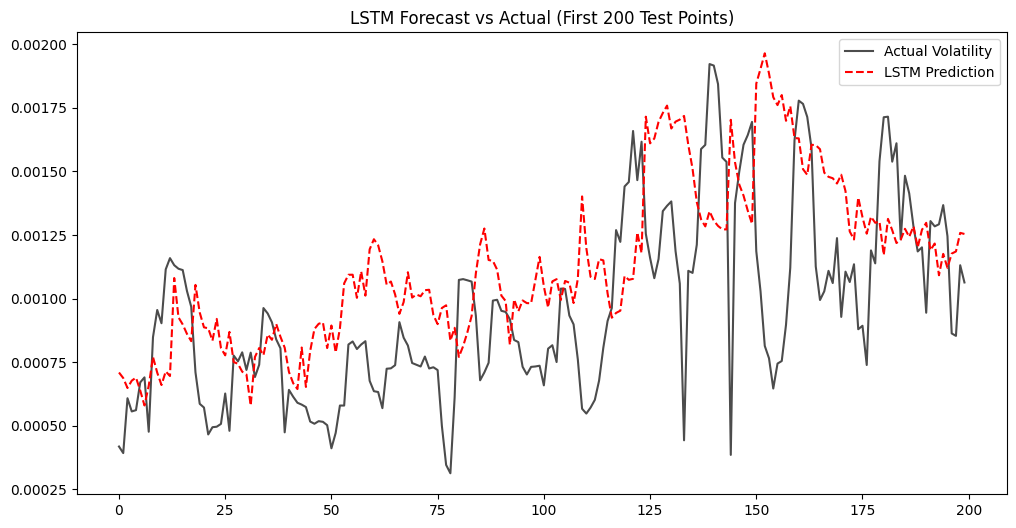

In [25]:
# RUN BTC RESULTS
# 1. Load the best saved model
model.load_state_dict(torch.load("btc_best_lstm_model.pth"))

# 2. Evaluate
preds, acts = evaluate_and_plot(model, btc_test_dl)

Running Inference on Test Set...

FINAL RESULTS:
   RMSE: 0.000861
   MAE:  0.000543


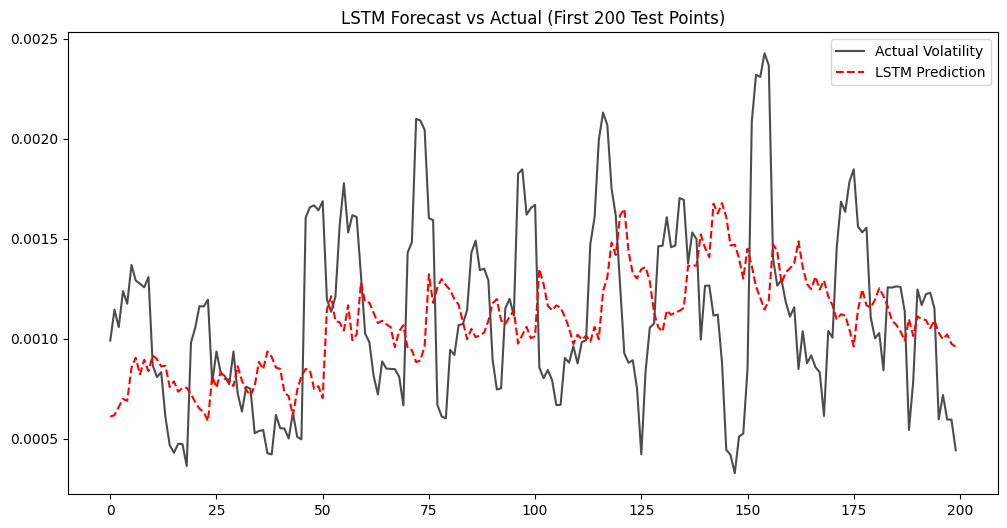

In [26]:
# RUN ETH RESULTS
# 1. Load the best saved model
model.load_state_dict(torch.load("eth_best_lstm_model.pth"))

# 2. Evaluate
preds, acts = evaluate_and_plot(model, eth_test_dl)

# Hyperparameter Tuning

In [ ]:
# @title
import random
import torch
import pandas as pd

# 1. Define the "Search Space" (The menu of options)
param_grid = {
    "hidden_size": [32, 64, 128],       # How big is the brain?
    "num_layers": [1, 2],               # How deep is the brain?
    "dropout": [0.0, 0.2, 0.5],         # How much to prevent memorization?
    "learning_rate": [0.001, 0.0005, 0.0001], # How fast to learn?
    "batch_size": [512, 1024, 2048]     # How big are the chunks?
}

def run_hyperparameter_tuning(num_trials=5, epochs_per_trial=3):
    print(f"Starting Random Search for {num_trials} trials...")

    results = []

    for trial in range(num_trials):
        # A. Pick Random Hyperparameters
        params = {k: random.choice(v) for k, v in param_grid.items()}
        print(f"\n--- Trial {trial+1}/{num_trials} ---")
        print(f"   Settings: {params}")

        # B. Prepare Data (Re-load if batch size changes)
        # Note: We use your existing function
        train_loader, val_loader, test_loader, input_dim = prepare_lstm_data(
            TARGET_SYMBOLS,
            best_features, # Use the features we selected earlier
            batch_size=params["batch_size"],
            seq_len=60
        )

        # C. Initialize Model
        model = VolatilityLSTM(
            input_size=input_dim,
            hidden_size=params["hidden_size"],
            num_layers=params["num_layers"],
            dropout=params["dropout"]
        )

        # D. Train (Short run to check potential)
        train_losses, val_losses = train_lstm_model(
            model,
            train_loader,
            val_loader,
            epochs=epochs_per_trial,
            lr=params["learning_rate"],
            save_path=f"trial_{trial}_model.pth" # Save each trial separately
        )

        # E. Record Result (Use the final validation loss)
        final_val_loss = val_losses[-1]
        print(f"   Result: Val Loss = {final_val_loss:.6f}")

        results.append({
            **params,
            "val_loss": final_val_loss,
            "trial_id": trial
        })

    # F. Analyze Results
    results_df = pd.DataFrame(results).sort_values(by="val_loss")
    print("\nTUNING COMPLETE! Best Configurations:")
    print(results_df.head())

    return results_df

# --- RUN THE TUNING ---
# We run 5 trials for 3 epochs each to save time.
# Once you find the best settings, you train THAT one for 15+ epochs.
tuning_results = run_hyperparameter_tuning(num_trials=5, epochs_per_trial=3)

# GARCH

In [ ]:
# @title
pip install arch

In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

# --- 1. CLASS DEFINITION (Same as before) ---
class AutoGARCH:
    def __init__(self, p_max=2, q_max=2):
        self.p_max = p_max
        self.q_max = q_max
        self.best_model = None
        self.best_result = None
        self.best_params = {}

    def fit(self, returns):
        best_bic = float('inf')
        for p in range(1, self.p_max + 1):
            for q in range(1, self.q_max + 1):
                try:
                    model = arch_model(returns, vol='Garch', p=p, q=q, dist='Normal', rescale=True)
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        result = model.fit(disp='off', show_warning=False)

                    if result.convergence_flag == 0 and result.bic < best_bic:
                        best_bic = result.bic
                        self.best_model = model
                        self.best_result = result
                        self.best_params = {'p': p, 'q': q}
                except Exception:
                    continue
        if not self.best_params:
            self.best_params = {'p': 1, 'q': 1}
        return self.best_result

# --- 2. LOOPING BENCHMARK FUNCTION ---
def run_garch_per_symbol(symbols, train_ratio=0.70):
    print("🚀 Starting GARCH Benchmark per Symbol...")

    # Store results to average later
    results = []

    # LOOP THROUGH EACH SYMBOL INDIVIDUALLY
    for sym in symbols:
        print(f"\n==========================================")
        print(f"   ANALYZING: {sym}")
        print(f"==========================================")

        # 1. Load Data for just THIS symbol
        # We use a list with 1 item to force the loader to just get this coin
        full_df = load_training_data([sym])

        if full_df is None or len(full_df) == 0:
            print(f"❌ No data found for {sym}")
            continue

        if "dt" in full_df.columns:
            full_df = full_df.sort_values("dt").set_index("dt")

        # 2. Prep Data
        data = full_df[["ret_1m", "rv_fwd_5m"]].dropna()
        returns = data["ret_1m"]
        actual_vol = data["rv_fwd_5m"]

        # 3. Split
        n = len(returns)
        split_point = int(n * train_ratio)
        train_returns = returns.iloc[:split_point]
        test_actuals = actual_vol.iloc[split_point:]

        # 4. Tune
        print(f"   🔍 Tuning parameters on {len(train_returns)} rows...")
        optimizer = AutoGARCH(p_max=2, q_max=2)
        optimizer.fit(train_returns)
        best_p = optimizer.best_params.get('p', 1)
        best_q = optimizer.best_params.get('q', 1)
        print(f"      Best Params: GARCH({best_p}, {best_q})")

        # 5. Fit & Forecast
        print("   🔮 Forecasting...")
        final_model = arch_model(returns, vol='Garch', p=best_p, q=best_q, dist='Normal', rescale=True)
        res = final_model.fit(last_obs=len(train_returns), disp='off')

        forecasts = res.forecast(horizon=5, start=len(train_returns))

        # 6. Process Results
        variance_forecasts = forecasts.variance.reindex(test_actuals.index)

        # Filter valid rows
        valid_mask = ~variance_forecasts.isna().all(axis=1)
        variance_forecasts = variance_forecasts[valid_mask]
        test_actuals_aligned = test_actuals[valid_mask]

        # Calculate Volatility (Sqrt of Sum of Variances)
        scale = res.scale
        total_variance = variance_forecasts.sum(axis=1)
        garch_pred_vol = np.sqrt(total_variance) / scale

        # 7. Metrics
        rmse = math.sqrt(mean_squared_error(test_actuals_aligned, garch_pred_vol))
        mae = mean_absolute_error(test_actuals_aligned, garch_pred_vol)

        print(f"   📊 {sym} RESULTS: RMSE={rmse:.6f} | MAE={mae:.6f}")
        results.append({'Symbol': sym, 'RMSE': rmse, 'MAE': mae})

        # 8. Plot (Optional - show just first 200 points)
        plt.figure(figsize=(10, 4))
        plt.plot(test_actuals_aligned.values[:200], label="Actual", color='black', alpha=0.6)
        plt.plot(garch_pred_vol.values[:200], label="GARCH", color='blue', linestyle='--')
        plt.title(f"{sym}: GARCH({best_p},{best_q}) Forecast")
        plt.legend()
        plt.show()

    # --- FINAL SUMMARY ---
    print("\n\n🏆 FINAL GARCH BENCHMARK SUMMARY:")
    summary_df = pd.DataFrame(results)
    print(summary_df)
    print(f"\nAverage RMSE: {summary_df['RMSE'].mean():.6f}")

# --- RUN IT ---
run_garch_per_symbol(TARGET_SYMBOLS)

In [ ]:
# @title
